In [1]:
%cd ../

/Users/sarchey1/paper/FederatedLearning


In [2]:
import warnings
warnings.simplefilter('ignore')

## Pytorch MNIST Experiment

### NN Models

As you see in the algorithm picture, the primal update needs a optimizer operator for the sampling set (line 6). We have implemented the optimizers discussed in the paper, both the logistic loss and squared error loss optimizers implementations with pytorch is available, also we have implemented the squared error loss optimizer using the fixed point equation in the `Networked Linear Regression` section of the paper.  

In [3]:
# %load algorithm/optimizer.py 
import torch
import abc
import numpy as np

from abc import ABC
import torch.nn.functional as F


# The SimpleLinear which is for MNIST experiment
class SimpleLinear(torch.nn.Module):

    def __init__(self, h1=2048):
        super().__init__()
        self.linear1 = torch.nn.Linear(28*28, h1)
        self.linear2 = torch.nn.Linear(h1, 2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)
                

# The SimpleLinear which is for MNIST experiment
class CombinedModel(torch.nn.Module):

    def __init__(self, h1=2048):
        super().__init__()
        self.models = []
        for i in range(40):
            model = SimpleLinear(h1)
            self.models.append(model)

    def forward(self, xs):
        preds = []
        for i, model in enumerate(self.models):
            x = xs[i]
            pred = model.forward(x)
#             pred = np.argmax(model.forward(x))
            preds.append(pred)
        return preds
    
    def parameters(self, recurse: bool = True):
        for model in self.models:
            for name, param in model.named_parameters(recurse=recurse):
                yield param


## Load MNIST data

We also proposed an experiment based on the MNIST dataset. Here we have two different clusters $C_1, C_2$. In order to simulate an environment where the data on each node is generated from a different distribution, for each cluster two different numbers (out of 10 available classes) is selected (
$C_1 \in \{0, 1\}$ and $C_2 \in \{2, 3\}$).
Each node of the empirical graph stands for a simple neural network with two Linear layers in which the dimension of the first layer's input is 28*28 and its output is 1 (with Relu activation function), and also the last layer has the output with dimension 2 (and Softmax activation function).


The training images for each cluster are splitted equally to the nodes in that cluster. Thus, the only difference between the nodes in the clusters is their training datasets. First, by using TSNE the dimension of each image ($d=28*28$) is reduced to $d^\prime=2$. Suppose that the training features for the node $i$ is $[img_i^1 ,\cdots, img_i^P] \in R^{784*P}$
, so the embedded features can be expressed by $embedded_i = [embedded_i^1,\cdots,embedded_i^P] \in R^{2*P}$. For calculating the similarities between the nodes, in order to calculate a consistent distance between the nodes, we consider the sorted embedded features, so $embedded_i = sorted([embedded_i^1,\cdots,embedded_i^P])$. Then
$\forall i \in N $ and $\forall j \in N$ 
 \begin{equation*}
     dist(i, j) = \frac{1}{P} \sum_{k=1}^{P} (embedded_i^k - embedded_j^k)^2.
 \end{equation*}

For each node the 6 nearest neighbours (the ones with the lowest distances) is selected and the edge weight between nodes i and j is defined by $w_{ij} = e^{-dist(i,j)}$. 

In [4]:
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
import json
from sklearn.manifold import TSNE


def get_images():
    transforms = torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                     ])
    mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)

    dl = DataLoader(mnist_dataset)

    X = dl.dataset.data # (60000,28, 28)
    y = dl.dataset.targets #(60000)

    # normalize to have 0 ~ 1 range in each pixel

    X = X / 255.0
    
    cluster_nums = [[0, 1], [2, 3]]
    
    cluster_data0 = np.concatenate((np.where(y==cluster_nums[0][0])[0], np.where(y==cluster_nums[0][1])[0]))
    random.shuffle(cluster_data0)
    
    cluster_data1 = np.concatenate((np.where(y==cluster_nums[1][0])[0], np.where(y==cluster_nums[1][1])[0]))
    random.shuffle(cluster_data1)
    
    cluster_data = [
        cluster_data0,
        cluster_data1,
    ]
    
    all_cluster_data = np.concatenate((cluster_data0 , cluster_data1))
    selected_X = X[all_cluster_data].reshape(-1, 28*28)
    selected_embedded = TSNE(n_components=2, learning_rate='auto',
                            init='random').fit_transform(selected_X)
    
    all_embeded = np.zeros((len(X), 2))
    all_embeded[all_cluster_data] = selected_embedded
    return X, y, cluster_data, cluster_nums, all_embeded


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()

        return super(NpEncoder, self).default(obj)
    
    
def save_data():
    X, y, cluster_data, cluster_nums, all_embeded = get_images()

    saved_data = {
        'X': X.tolist(), 
        'y': y.tolist(),
        'cluster_data': cluster_data,
        'cluster_nums': cluster_nums,
        'all_embeded': all_embeded,
    }
    with open('./experiments/data/MNIST/mnist_data.json', 'w') as f:
        f.write(json.dumps(saved_data, cls=NpEncoder))
    
def loead_data():
    with open('./experiments/data/MNIST/mnist_data.json', 'r') as f:
        saved_data = json.load(f)
    
    X = torch.tensor(saved_data['X'])
    y = torch.tensor(saved_data['y'])
    cluster_data = np.array(saved_data['cluster_data'])
    cluster_nums = np.array(saved_data['cluster_nums'])
    all_embeded = np.array(saved_data['all_embeded'])
    
    return X, y, cluster_data, cluster_nums, all_embeded



## Build the graph

In [5]:
# from algorithm.optimizer import *
from sklearn.metrics import mean_squared_error

def build_graph(cluster_sizes, X, y, cluster_data, all_embeded, num_neig=3, h1=200):
    '''
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = np.sum(cluster_sizes)
    E = N-1
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
#     feature_size = 5000
    feature_size = int(10000//cluster_sizes[0])
    train_size = int(feature_size*0.8)
    
    # create the data of each node needed for the algorithm 1 
    node_degrees = np.full(N, 1.0/num_neig)
#     np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    embeded_features = []
    cnt = 0
    for i, cluster_size in enumerate(cluster_sizes):
        for j in range(cluster_size):
            
#             indices = np.array(random.sample(cluster_data[i], feature_size))
#             features = X[indices][:train_size]
#             res = all_embeded[indices][:train_size]
#             res = np.sort(res, axis=0)
#             embeded_features.append(res)
#             test_features = X[indices][train_size:]
#             '''
#             features: the feature vector of node i 
#             '''
#             label = y[indices][:train_size]
#             test_label = y[indices][train_size:]
            
#             label[label == cluster_nums[i][0]] = 0
#             label[label == cluster_nums[i][1]] = 1
            
            features = X[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            res = all_embeded[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            res = np.sort(res, axis=0)
            embeded_features.append(res)
            test_features = X[cluster_data[i][j*feature_size:(j+1)*feature_size]][train_size:]
            '''
            features: the feature vector of node i 
            '''
            label = y[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            test_label = y[cluster_data[i][j*feature_size:(j+1)*feature_size]][train_size:]
            
            label[label == cluster_nums[i][0]] = 0
            label[label == cluster_nums[i][1]] = 1
            
            test_label[test_label == cluster_nums[i][0]] = 0
            test_label[test_label == cluster_nums[i][1]] = 1
            '''
            label: the label of the node i
            '''
            
            true_labels.append(label)
            

            '''
            model : the linear model for the node i 
            optimizer : the optimizer model for the node i 
            ''' 
            
            datapoints[cnt] = {
                'features': features,
                'test_features': test_features,
                'degree': node_degrees[cnt],
                'label': label,
                'test_label': test_label,
            }
            cnt += 1
            
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    E = N*num_neig
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    cnt = 0
    for i in range(N):
        dists = []
        for j in range(N):
            dists.append(mean_squared_error(embeded_features[i], embeded_features[j]))
        node_dists = np.argsort(dists)
        for k in range(num_neig):
            neig = node_dists[k+1]
            B[cnt, i] = 1
            B[cnt, neig] = -1
            weight_vec[cnt] = np.exp(-dists[neig])
            cnt += 1

    weight_vec = (weight_vec - np.min(weight_vec)) / (np.max(weight_vec) - np.min(weight_vec))
    

    return B, weight_vec, np.array(true_labels), datapoints


### Similarity graph with Two Clusters

In [6]:
%%capture
# from sparsebm import generate_SBM_dataset
import networkx as nx


def get_graph_data(X, y, cluster_data, all_embeded, n_neig=3, h1=200):
    '''
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    cluster_sizes = [100, 100]
    cluster_sizes = [20, 20]
    
    return build_graph(cluster_sizes, X, y, cluster_data, all_embeded, n_neig, h1)


# save_data()
X, y, cluster_data, cluster_nums, all_embeded = loead_data()

##### Plot the test accuracy vs iterations for algorithm1

In [7]:
n_epochs = 200

train_batch_size = 100
test_batch_size = 25
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

B, weight_vec, true_labels, datapoints = get_graph_data(X, y, cluster_data, all_embeded, n_neig=6, h1=1)
weight_vec = torch.tensor(weight_vec)

_cluster_data = np.concatenate((cluster_data[0], cluster_data[1]))
features = X[_cluster_data]
labels = y[_cluster_data]
print(np.unique(labels))


[0 1 2 3]


In [8]:
import torch.optim as optim

network = CombinedModel(1)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


train_losses = []
train_counter = []
test_losses = []

def my_loss(output, target, network, B, weight_vec):
    loss = 0
    E, N = B.shape
    for idx in range(N):
        loss += F.nll_loss(output[idx], target[idx])
             
        neighs = np.where(B[:, idx] == -1)[0]
        for e in neighs:
            j = np.where(B[e]==1)[0][0]
            loss += weight_vec[e] * torch.mean((
                network.models[j].linear1.weight.data - network.models[idx].linear1.weight.data)**2)
            loss += weight_vec[e] * torch.mean((
                network.models[j].linear2.weight.data - network.models[idx].linear2.weight.data)**2)
        
    return loss

def train(epoch, datapoints, is_print=False):
    network.train()
    n_data = len(datapoints[0]['features'])
    shuffle_indices = [i for i in range(n_data)]
    random.shuffle(shuffle_indices)
    for batch_idx in range(n_data//train_batch_size):
        optimizer.zero_grad()
        
        splited_data = [datapoints[i]['features'][batch_idx*train_batch_size:(batch_idx+1)*train_batch_size]
                         for i in datapoints]
        splited_target = [datapoints[i]['label'][batch_idx*train_batch_size:(batch_idx+1)*train_batch_size]
                         for i in datapoints]        
        output = network(splited_data)
        loss = my_loss(output, splited_target, network, B, weight_vec)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and is_print:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * train_batch_size, train_batch_size,
            100. * batch_idx / (n_data//train_batch_size), loss.item()))
            
def test(datapoints, is_print=False):
    network.eval()
    test_loss = 0
    correct = 0
    totals = 0
    n_data = len(datapoints[0]['test_features'])
    with torch.no_grad():
        for batch_idx in range(n_data//train_batch_size):
            splited_data = [datapoints[i]['test_features'][batch_idx*test_batch_size:(batch_idx+1)*test_batch_size]
                         for i in datapoints]
            splited_target = [datapoints[i]['test_label'][batch_idx*test_batch_size:(batch_idx+1)*test_batch_size]
                         for i in datapoints]
            output = network(splited_data)
            test_loss = my_loss(output, splited_target, network, B, weight_vec)
            preds = [item.data.max(1, keepdim=True)[1] for item in output]
            for i, pred in enumerate(preds):
                correct += pred.eq(splited_target[i].data.view_as(pred)).sum()
                totals += len(splited_target[i])
    test_loss /= totals
    test_losses.append(test_loss)
    if is_print:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, totals,
        100. * correct / totals))
    return correct / totals
    
test(datapoints, True)
accs = []
for epoch in range(1, n_epochs + 1):
    if epoch % 20 == 0:
        train(epoch, datapoints, True)
        acc = test(datapoints, True)
        print('------------------------')
    else:
        train(epoch, datapoints, False)
        acc = test(datapoints, False)
    accs.append(acc)
  
print()
test(datapoints, True)


Test set: Avg. loss: 0.0432, Accuracy: 505/1000 (50%)

Train Epoch: 20 [0/100 (0%)]	Loss: 29.194979

Test set: Avg. loss: 0.0295, Accuracy: 782/1000 (78%)

------------------------
Train Epoch: 40 [0/100 (0%)]	Loss: 25.820084

Test set: Avg. loss: 0.0265, Accuracy: 949/1000 (95%)

------------------------
Train Epoch: 60 [0/100 (0%)]	Loss: 24.673958

Test set: Avg. loss: 0.0254, Accuracy: 966/1000 (97%)

------------------------
Train Epoch: 80 [0/100 (0%)]	Loss: 24.438416

Test set: Avg. loss: 0.0253, Accuracy: 971/1000 (97%)

------------------------
Train Epoch: 100 [0/100 (0%)]	Loss: 24.695368

Test set: Avg. loss: 0.0257, Accuracy: 974/1000 (97%)

------------------------
Train Epoch: 120 [0/100 (0%)]	Loss: 25.181816

Test set: Avg. loss: 0.0263, Accuracy: 976/1000 (98%)

------------------------
Train Epoch: 140 [0/100 (0%)]	Loss: 25.787136

Test set: Avg. loss: 0.0270, Accuracy: 976/1000 (98%)

------------------------
Train Epoch: 160 [0/100 (0%)]	Loss: 26.461222

Test set: Av

tensor(0.9780)

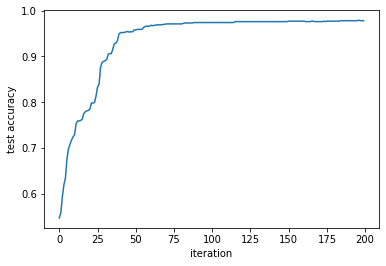

In [9]:
import matplotlib.pyplot as plt


x = [i for i in range(len(accs))]
plt.plot(x, accs)
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.show()
plt.close()